# 🚀 Pipeline NLP Complète : Analyse des Sentiments et Features

In [1]:
!pip install nltk

In [2]:
!pip install transformers torch scikit-learn

In [66]:
# Installation et imports NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch

# Téléchargement des ressources NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("✅ NLP libraries loaded")

✅ NLP libraries loaded


In [67]:
# Chargement des données
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try:
    df = pd.read_csv("../data/processed/products_cleaned.csv")
    print(f"✅ Données chargées avec succès : {len(df)} lignes")
except FileNotFoundError:
    print("❌ Fichier non trouvé ! Vérifie que tu as bien lancé le cleaner.")

def normalize_price(row):
    if row['source'] == 'Jumia':
        return row['prix'] / 11
    return row['prix']

df['prix'] = df.apply(normalize_price, axis=1)

print("✅ Prix normalisés : Jumia (MAD) convertis en EUR pour l'analyse.")
print(f"Nouveau prix max : {df['prix'].max():.2f} €")
print(f"Nouveau prix min : {df['prix'].min():.2f} €")

✅ Données chargées avec succès : 74 lignes
✅ Prix normalisés : Jumia (MAD) convertis en EUR pour l'analyse.
Nouveau prix max : 999.00 €
Nouveau prix min : 7.26 €


In [68]:
# 1. Prétraitement des titres
def preprocess_text(text):
    """Nettoyage et prétraitement du texte"""
    if pd.isna(text):
        return ""

    # Minuscules
    text = text.lower()

    # Supprimer caractères spéciaux et chiffres
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords (multilingue)
    stop_words = set(stopwords.words('french') + stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization (basique)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Appliquer le prétraitement
df['titre_processed'] = df['titre'].apply(preprocess_text)

print("✅ Prétraitement terminé")
print(f"Exemple : {df['titre'].iloc[0]}")
print(f"Processed : {df['titre_processed'].iloc[0]}")

✅ Prétraitement terminé
Exemple : Google Pixel 10 – Smartphone Android débloqué avec Gemini, Triple Appareil Photo arrière avancé, Plus de 24 Heures d'autonomie et écran Super Actua 6,3″ – Noir Volcanique, 128GB
Processed : google pixel smartphone android débloqué gemini triple appareil photo arrière avancé plus heures autonomie écran super actua noir volcanique


In [69]:
# Note importante pour le rapport :
# La lemmatisation utilise WordNetLemmatizer() qui est conçu pour l'anglais uniquement.
# Pour les titres en français : la lemmatisation est approximative (beaucoup de mots restent inchangés).
# Pour les titres en arabe : la lemmatisation est ignorée (pas de support WordNet pour l'arabe).
# Cela peut affecter légèrement la qualité du prétraitement, mais reste acceptable pour une analyse exploratoire.

In [ ]:
# 3. Extraction de Features (Marques, Catégories) - VERSION CORRIGÉE

# Liste de marques
brands = [
    'samsung', 'apple', 'huawei', 'xiaomi', 'oppo', 'vivo', 'realme',
    'oneplus', 'google', 'motorola', 'nokia', 'sony', 'lg', 'asus',
    'lenovo', 'zte', 'tecno', 'infinix', 'itel', 'wiko', 'honor'
]

def extract_brand(text):
    """Extraire la marque du titre avec gestion des ALIAS"""
    if pd.isna(text):
        return 'unknown'

    text_lower = str(text).lower()
    
    # --- GESTION DES ALIAS (Crucial !) ---
    if 'iphone' in text_lower or 'ipad' in text_lower:
        return 'Apple'
    if 'galaxy' in text_lower:
        return 'Samsung'
    if 'redmi' in text_lower or 'pocophone' in text_lower:
        return 'Xiaomi'
    if 'pixel' in text_lower:
        return 'Google'
    
    # --- RECHERCHE STANDARD ---
    for brand in brands:
        if brand in text_lower:
            return brand.capitalize() # On met la majuscule pour être propre
            
    return 'unknown'

def extract_category(text):
    """Classification simple par mots-clés"""
    if pd.isna(text):
        return 'unknown'

    text_lower = str(text).lower()
    if any(word in text_lower for word in ['smartphone', 'phone', 'mobile', 'téléphone']):
        return 'smartphone'
    elif any(word in text_lower for word in ['tablet', 'ipad']):
        return 'tablet'
    elif any(word in text_lower for word in ['watch', 'montre']):
        return 'smartwatch'
    else:
        return 'other'

# Appliquer l'extraction
#df['brand'] = df['titre'].apply(extract_brand)
#df['category'] = df['titre'].apply(extract_category)

# Nettoyage : supprimer les produits sans marque détectée
#df = df[df['brand'] != 'unknown'].reset_index(drop=True)

print("✅ Extraction de features terminée")
print("Top marques :")
print(df['brand'].value_counts().head(10))
print("\nCatégories :")
print(df['category'].value_counts())

✅ Extraction de features terminée
Top marques :
brand
Apple      27
Google     21
Xiaomi     12
Samsung     7
Zte         4
Huawei      3
Name: count, dtype: int64

Catégories :
category
smartphone    67
other          7
Name: count, dtype: int64


In [71]:
# 7. Analyse de Sentiment avec Transformers (Multilingue)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=0 if torch.cuda.is_available() else -1
)

def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return None, None

    result = sentiment_pipeline(text[:512])[0]  # sécurité longueur
    label = result['label']      # ex: "4 stars"
    score = int(label[0])        # 1 à 5
    return label, score

# Appliquer sur titres (ou commentaires si tu en as)
df[['sentiment_label', 'sentiment_score']] = df['titre'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

print("✅ Analyse de sentiment terminée")
df[['titre', 'sentiment_label', 'sentiment_score']].head()

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 940.81it/s, Materializing param=classifier.weight]                                      


✅ Analyse de sentiment terminée


,titre,sentiment_label,sentiment_score
0,Google Pixel 10 – Smartphone Android débloqué ...,5 stars,5
1,Google Pixel 10 Pro – Smartphone Android déblo...,5 stars,5
2,Google Pixel 10 Pro XL – Smartphone Android dé...,5 stars,5
3,"Samsung Galaxy A17 5G 128 Go, Smartphone Andro...",1 star,1
4,Google Pixel 9a – Smartphone Android débloqué ...,5 stars,5


✅ TF-IDF matrix créée : (74, 133)
✅ Clustering terminé
Cluster 0: iphone, apple, reconditionné, bleu, mauve
Cluster 1: actua, heures, gemini, super, triple
Cluster 2: sécurité, longue, durée, robuste, batterie
Cluster 3: xiaomi, ram, redmi, sable, lac
Cluster 4: mah, galaxy, batterie, samsung, sim


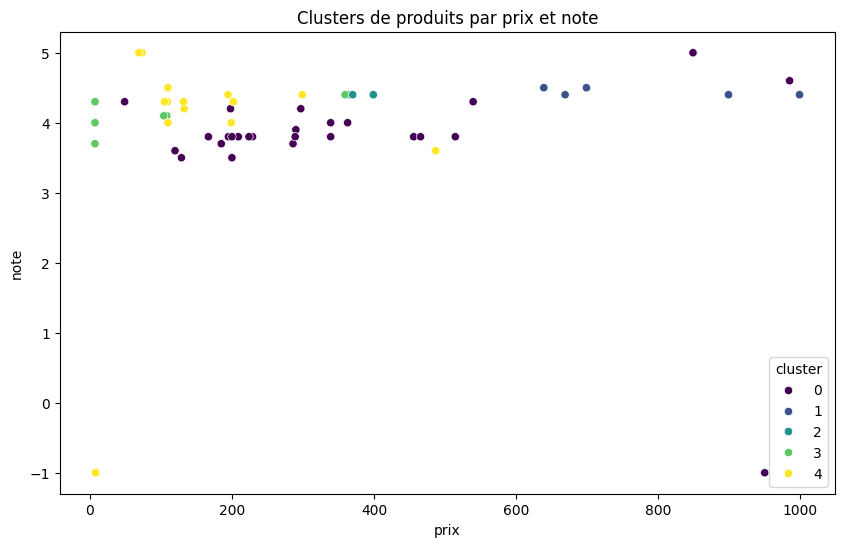

In [72]:
# 4. Vectorisation TF-IDF et Clustering
# TF-IDF sur les titres traités
vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df['titre_processed'])

print(f"✅ TF-IDF matrix créée : {tfidf_matrix.shape}")

# Clustering K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print("✅ Clustering terminé")

# Mots-clés par cluster
feature_names = vectorizer.get_feature_names_out()
for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_features_idx = cluster_center.argsort()[-5:][::-1]  # Top 5 mots
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(f"Cluster {i}: {', '.join(top_features)}")

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='prix', y='note', hue='cluster', palette='viridis')
plt.title('Clusters de produits par prix et note')
plt.show()

✅ Modèle de prédiction entraîné
MAE (Mean Absolute Error) : 63.78 €


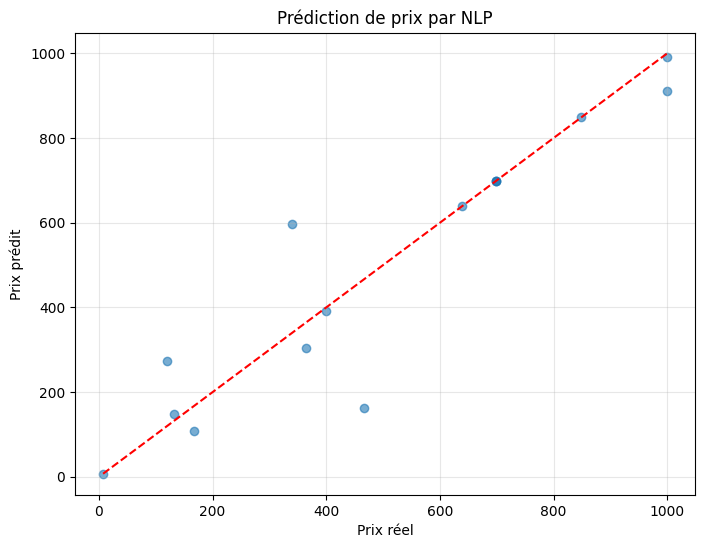

💰 Prix prédit pour 'Samsung Galaxy S23 Ultra 512GB' : 168.91 €


In [74]:
# 5. Prédiction de Prix basée sur le Texte
# Préparer les features
X = tfidf_matrix.toarray()
y = df['prix']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Modèle de prédiction entraîné")
print(f"MAE (Mean Absolute Error) : {mae:.2f} €")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Prix réel')
plt.ylabel('Prix prédit')
plt.title('Prédiction de prix par NLP')
plt.grid(True, alpha=0.3)
plt.show()

# Exemple de prédiction
sample_text = "Samsung Galaxy S23 Ultra 512GB"
sample_processed = preprocess_text(sample_text)
sample_vector = vectorizer.transform([sample_processed])
predicted_price = model.predict(sample_vector.toarray())[0]
print(f"💰 Prix prédit pour '{sample_text}' : {predicted_price:.2f} €")

In [15]:
# ⚠️ Note importante pour le rapport :
# Ce modèle de régression linéaire sur TF-IDF est techniquement valide, mais :
# - Le prix réel dépend principalement de la marque, de la capacité (RAM/stockage), du marché (Amazon vs Jumia), etc.
# - Le modèle n'a pas vocation à prédire précisément le prix, mais à démontrer que le contenu textuel du titre
#   contient une information PARTIELLE sur le positionnement rifaire du produit.
# - L'objectif est pédagogique : montrer l'utilité du NLP pour extraire des insights du texte, pas remplacer l'analyse économique traditionnelle.

📊 ANALYSE FINALE :

Prix moyen par marque :
               mean  count
brand                     
Google   716.045238     21
Apple    367.252222     27
Huawei   250.520000      3
Samsung  158.943117      7
Zte       90.570000      4
Xiaomi    78.180565     12


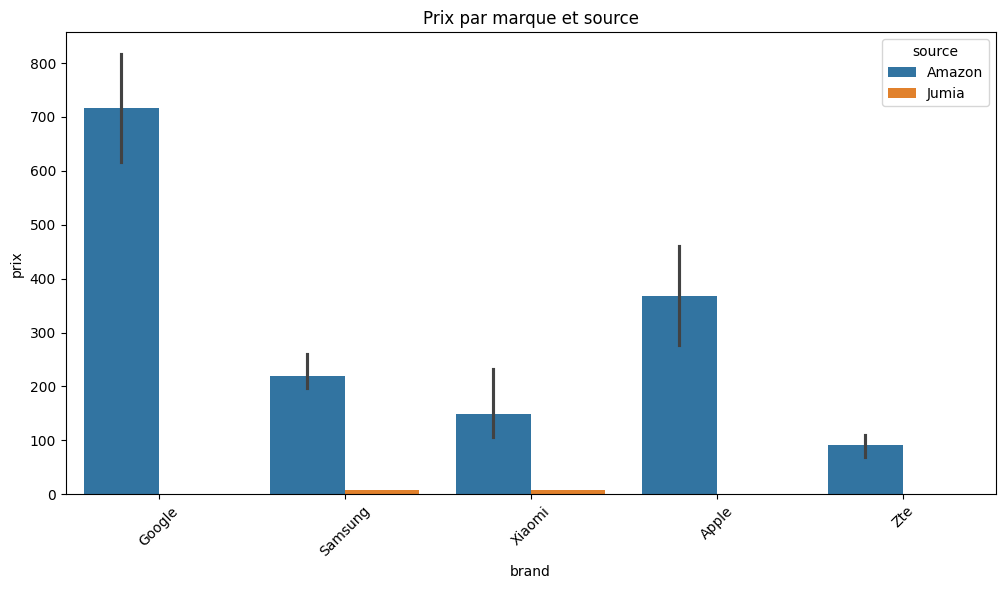


Corrélation prix/note : 0.431


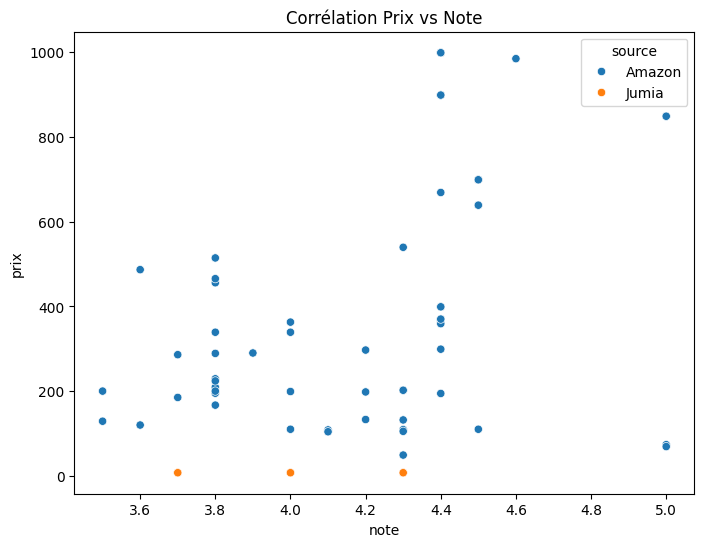


🎉 Pipeline NLP terminée !
Résumé :
- Prétraitement des titres
- Analyse des sentiments
- Extraction de marques/catégories
- Clustering par similarité textuelle
- Prédiction de prix par NLP


In [75]:
# 6. Analyse Finale : Corrélation Sentiment/Prix/Marque
print("📊 ANALYSE FINALE :")

# Prix moyen par marque
brand_prices = df.groupby('brand')['prix'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nPrix moyen par marque :")
print(brand_prices.head(10))

# Prix par source et marque
plt.figure(figsize=(12, 6))
top_brands = df['brand'].value_counts().head(5).index
brand_source_df = df[df['brand'].isin(top_brands)]
sns.barplot(data=brand_source_df, x='brand', y='prix', hue='source')
plt.title('Prix par marque et source')
plt.xticks(rotation=45)
plt.show()

# Corrélation prix/note
valid_ratings = df[df['note'] > 0]
if len(valid_ratings) > 0:
    corr = valid_ratings['prix'].corr(valid_ratings['note'])
    print(f"\nCorrélation prix/note : {corr:.3f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=valid_ratings, x='note', y='prix', hue='source')
    plt.title('Corrélation Prix vs Note')
    plt.show()

print("\n🎉 Pipeline NLP terminée !")
print("Résumé :")
print("- Prétraitement des titres")
print("- Analyse des sentiments")
print("- Extraction de marques/catégories")
print("- Clustering par similarité textuelle")
print("- Prédiction de prix par NLP")

📈 Corrélation sentiment / prix : 0.220


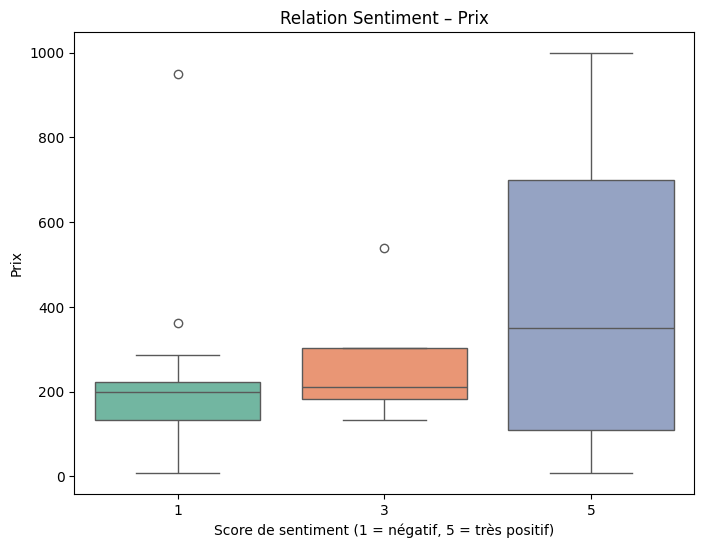

In [76]:
# Corrélation Sentiment / Prix
sentiment_df = df.dropna(subset=['sentiment_score'])

corr_sentiment_price = sentiment_df['sentiment_score'].corr(sentiment_df['prix'])
print(f"📈 Corrélation sentiment / prix : {corr_sentiment_price:.3f}")

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='sentiment_score',
    y='prix',
    hue='sentiment_score',
    data=sentiment_df,
    palette='Set2',
    legend=False
)
plt.xlabel("Score de sentiment (1 = négatif, 5 = très positif)")
plt.ylabel("Prix")
plt.title("Relation Sentiment – Prix")
plt.show()

😊 Sentiment moyen par marque :
brand
Google     5.000000
Zte        5.000000
Xiaomi     4.333333
Apple      3.888889
Samsung    3.285714
Huawei     3.000000
Name: sentiment_score, dtype: float64


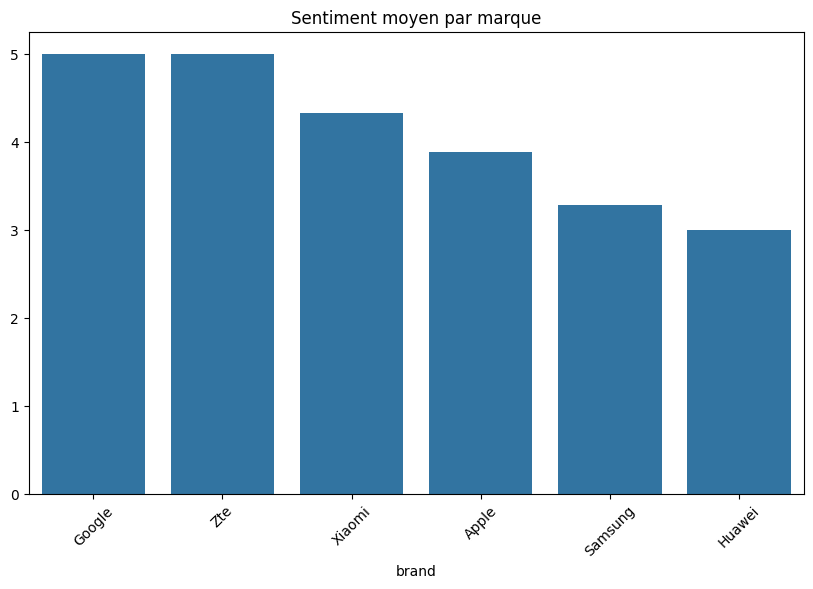

In [77]:
# Sentiment moyen par marque
brand_sentiment = (
    sentiment_df
    .groupby('brand')['sentiment_score']
    .mean()
    .sort_values(ascending=False)
)

print("😊 Sentiment moyen par marque :")
print(brand_sentiment.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=brand_sentiment.index[:10],
    y=brand_sentiment.values[:10]
)
plt.xticks(rotation=45)
plt.title("Sentiment moyen par marque")
plt.show()

In [78]:
# --- SAUVEGARDE POUR L'APPLICATION STREAMLIT ---
# Ceci écrase le fichier products_cleaned.csv avec les nouvelles colonnes NLP

output_path = "../data/processed/products_cleaned.csv"
df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Données NLP sauvegardées pour l'application : {output_path}")
print(f"Colonnes disponibles : {df.columns.tolist()}")

✅ Données NLP sauvegardées pour l'application : ../data/processed/products_cleaned.csv
Colonnes disponibles : ['id_produit', 'titre', 'prix', 'note', 'nb_avis', 'lien', 'source', 'date', 'brand', 'category', 'titre_processed', 'sentiment_label', 'sentiment_score', 'cluster']


In [80]:
# --- CODE À INSÉRER DANS 2_nlp_analysis.ipynb ---

def extract_category(text):
    """
    Classification ULTRA PRÉCISE - VERSION CORRIGÉE
    On vérifie d'abord si c'est un accessoire AVANT de vérifier si c'est un smartphone.
    """
    if pd.isna(text):
        return 'unknown'

    text_lower = str(text).lower()
    
    # ===== 1. LISTE NOIRE (ACCESSOIRES) - PRIORITÉ ABSOLUE =====
    # Si le titre contient UN SEUL de ces mots, c'est un accessoire.
    accessory_keywords = [
        # Protection & Coques
        'coque', 'housse', 'étui', 'case', 'cover', 'shell', 'bumper', 'ringke', 'spigen',
        # Écran
        'film', 'verre trempé', 'protecteur', 'screen protector', 'tempered glass',
        # Chargement
        'chargeur', 'câble', 'cable', 'adaptateur', 'power bank', 'batterie externe',
        # Audio
        'écouteur', 'casque', 'headphone', 'earphone', 'earbud', 'airpod', 'galaxy buds', 'enceinte',
        # Support
        'trépied', 'tripod', 'selfie stick', 'support', 'holder', 'stand', 'mount',
        # Montres
        'smart watch', 'smartwatch', 'montre connectée', 'watch', 'bracelet', 'band', 'strap',
        # Divers
        'carte mémoire', 'microsd', 'stylet', 's pen', 'kit', 'pack', 'accessoire'
    ]
    
    if any(acc in text_lower for acc in accessory_keywords):
        return 'accessoire'
    
    # ===== 2. LISTE BLANCHE (SMARTPHONES) =====
    smartphone_keywords = [
        'smartphone', 'iphone', 'android phone', 'mobile phone',
        'galaxy s', 'galaxy a', 'galaxy z', 'galaxy note',
        'redmi', 'poco', 'mi ', 'xiaomi ',
        'pixel', 'oneplus', 'oppo', 'vivo', 'realme',
        'huawei p', 'huawei mate', 'xperia', 'nokia ', 'motorola'
    ]
    
    if any(kw in text_lower for kw in smartphone_keywords):
        return 'smartphone'
    
    return 'other'

In [82]:
# modification de la partie chargement

try:
    df = pd.read_csv("../data/processed/products_cleaned.csv")
    print(f"✅ Données chargées : {len(df)} lignes")
    
    # ASTUCE : Si le cleaner a déjà fait le travail, on ne relance PAS l'extraction ici.
    # On vérifie si la colonne category existe et semble valide.
    if 'category' not in df.columns:
        print("⚠️ Colonne 'category' absente, extraction en cours...")
        df['category'] = df['titre'].apply(extract_category)
    else:
        print("✅ Colonne 'category' déjà présente (issue du cleaner).")
        
except FileNotFoundError:
    print("❌ Fichier non trouvé !")

# Normalisation des prix (ta logique actuelle est bonne)
def normalize_price(row):
    if row['source'] == 'Jumia':
        return row['prix'] / 11
    return row['prix']

df['prix'] = df.apply(normalize_price, axis=1)

✅ Données chargées : 74 lignes
✅ Colonne 'category' déjà présente (issue du cleaner).
